Newton's Method for Logistic Regression is implemented in [newton.py](https://github.com/charliemoore00/charliemoore00.github.io/blob/main/posts/newtons-method/newton.py)

## Abstract

This blog post contains an implementation of Newton's Method for Logistic Regression, located in the newton.py class available above. This is an alternative optimizer to Gradient Descent. This blog post will conduct a few experiments about how Newton's Method compares to Gradient Descent in terms of the speed it takes to converge, and also the computation cost.

In [19]:
%load_ext autoreload
%autoreload 2
from newton import LogisticRegression, GradientDescentOptimizer, NewtonOptimizer
import torch
from matplotlib import pyplot as plt # type: ignore

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Part A: Implement `NewtonOptimizer`

Newton’s Method is a second-order optimization technique. This means that it requires information about the second derivatives of the loss function  as well as the first derivatives. Here’s how Newton’s method works:

1. We compute the usual gradient $\nabla L(\mathbf{w})$, which is the vector of first derivatives of $L$.

2. We also compute the Hessian Matrix, which is the matrix of second derivatives of $L$. For logistic regression, the Hessian is the matrix $\mathbf{H}(\mathbf{w}) \in \mathbb{R}^{p \times p}$ with entries
\begin{aligned}
h_{ij}(\mathbf{w}) = \sum_{k = 1}^n x_{ki}x_{kj}\sigma(s_k)(1-\sigma(s_k))\;
\end{aligned}
To compute this matrix, we'll use the formula $\mathbf{H}(\mathbf{w}) = \mathbf{X}^T\mathbf{D}(\mathbf{w})\mathbf{X}$ where $D$ is the diagonal matrix with entries $d_{kk}(\mathbf{w}) = \sigma(s_k)(1-\sigma(s_k))$.

3. Once we know how to calculate the gradient and the Hessian, we repeat the update
\begin{aligned}
w \gets w - \alpha \mathbf{H}(\mathbf{w})^{-1} \nabla L (\mathbf{w})\;
\end{aligned}
until convergence. Here, $\alpha > 0$ is the learning rate and $\mathbf{H}(\mathbf{w})^{-1}$ is the matrix inverse of the Hessian Matrix.


The newton.py file linked at the top implements a `NewtonOptimizer` class that uses Newton's method to estimate **w** for a `LogisticRegression` model.

## Part B: Experimenting

1. When $\alpha$ is chosen appropriately, Newton's method converges to the correct choice of **w**.
2. Under at least some circumstances, Newton's method can converge *much* faster than standard gradient descent, in the sense of decreasing the empirical risk.
3. If $\alpha$ is too large, Newton's method fails to converge.

### Generating Experimental Data

Here is a method to generate data. The parameters are:

- `n_points`: the number of points
- `p_dims`: the number of features
- `noise`: the difficulty of the classification problem

In [20]:
def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

X_rand, y_rand = classification_data(noise = 0.5)

### Training the Model

We'll create train and plot methods for both Newton's method and regular Gradient Descent to show differences.

#### Gradient Descent Training

In [21]:
def train_and_plot_gradient_descent(X, y, alpha, beta, iterations=100):
    # initialize a logistic regression and gradient descent optimizer
    LR = LogisticRegression() 
    opt = GradientDescentOptimizer(LR)
    # to keep track of the loss to plot it
    loss_vec = []

    for _ in range(iterations):

       # keep track of the loss over time. 
        loss = LR.loss(X, y)
        loss_vec.append(loss)
        # use GradientDescentOptimizer's step function
        opt.step(X, y, alpha, beta)

    # plot the loss
    plt.plot(torch.arange(1, len(loss_vec) +1), loss_vec, color="black")
    plt.semilogx()
    labs = plt.gca().set(xlabel = "Number of Gradient Descent iterations", ylabel="loss")

#### Newton's Method Training

In [22]:
def train_and_plot_newton_optimizer(X, y, alpha, iterations=100):
    # initialize a logistic regression and gradient descent optimizer
    LR = LogisticRegression() 
    opt = NewtonOptimizer(LR)
    # to keep track of the loss to plot it
    loss_vec = []

    for _ in range(iterations):
       # keep track of the loss over time. 
        loss = LR.loss(X, y)
        loss_vec.append(loss)
        # use NewtonOptimizer's step function
        opt.step(X, y, alpha)

    # plot the loss
    plt.plot(torch.arange(1, len(loss_vec) +1), loss_vec, color="black")
    plt.semilogx()
    labs = plt.gca().set(xlabel = "Number of Newton Optimizer iterations", ylabel="loss")

#### **Experiment #1:** When $\alpha$ is chosen appropriately, Newton's method converges to the correct choice of **w**.

First, let's generate some data:

In [23]:
X_exp, y_exp = classification_data(n_points = 3000, noise = 0.5, p_dims = 2)

Then we'll train and plot our data with an $\alpha$ value of 200:

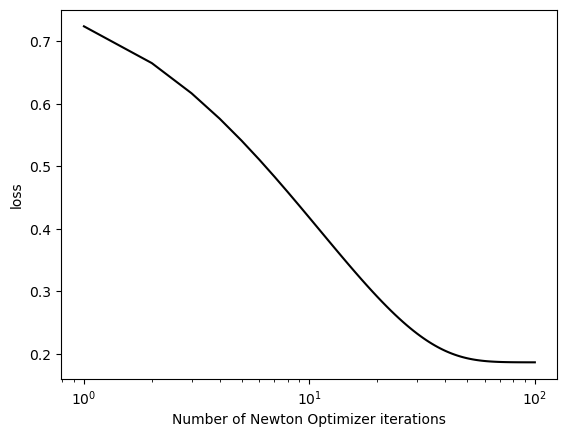

In [24]:
train_and_plot_newton_optimizer(X_exp, y_exp, 200, iterations = 100)

We can see of Logistic Regression with a Newton Optimizer does indeed **converge** within 100 iterations!

#### **Experiment #2:** Under at least some circumstances, Newton's method can converge *much* faster than standard gradient descent

Let's train and plot both gradient descent **and** Newton's method on the same data as before, but on 1000 iterations:

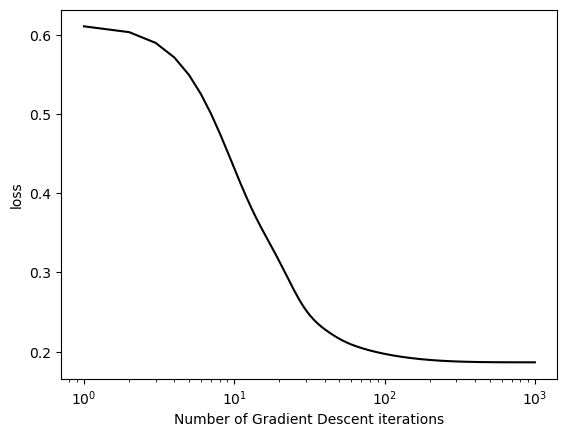

In [25]:
# gradient descent
train_and_plot_gradient_descent(X_exp, y_exp, 0.1, 0.9, iterations = 1000)

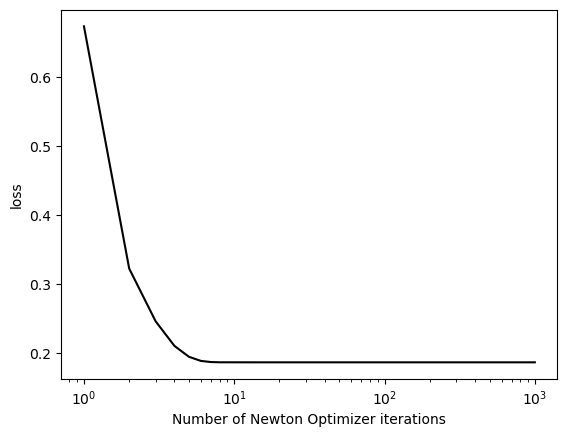

In [26]:
# Newton's method
train_and_plot_newton_optimizer(X_exp, y_exp, 2000, iterations=1000)

We can see that while it takes gradient descent between 100-1000 iterations to converge, it takes Newton's method **less than 10**. This is over a 10x speedup! But keep in mind this data has a low number of features.

#### **Experiment #3:** If $\alpha$ is too large, Newton's method fails to converge.

Let's set the alpha to a really high number and see what happens, keeping the same parameters as before:

In [29]:
train_and_plot_newton_optimizer(X_exp, y_exp, 9999, iterations=1000)

RuntimeError: torch.linalg.inv: The diagonal element 1 is zero, the inversion could not be completed because the input matrix is singular.

We end up getting the following error:
> RuntimeError: torch.linalg.inv: The diagonal element 1 is zero, the inversion could not be completed because the input matrix is singular.

Since our alpha value was so large, when we ran the `NewtonOptimizer.step` method, the updates to the weights were so large that it diverged instead of converged.

## Part C: Operation Counting

In high-dimensional optimization, the number of features p can be very large. This can be a problem for Newton’s method, because the operation of inverting a $p\times p$ matrix requires $O(p^\gamma)$ operations for some $2 \leq \gamma <3$.  Multiplying the gradient by the Hessian also requires O(p^2) operations.

Assume that it costs c computational units to compute the loss $L$, $2c$ units to compute the gradient $\nabla L$, and $pc$ units to compute the Hessian. Suppose further that it costs $k_1p^\gamma$ units to invert a $p\times p$ matrix and $k_2p^{2}$ units to perform the matrix-vector multiplication required by Newton’s method.

Finally, suppose that Newton’s method converges to an adequate solution in $t_\mathrm{nm}$ steps, while gradient descent converges to an adequate solution in $t_\mathrm{gd}$ steps.

Under these assumptions, write expressions describing the total computational costs of Newton’s method as compared to gradient descent. How much smaller must $t_\mathrm{nm}$ be than $t_\mathrm{gd}$ in order to ensure that Newton’s method will require fewer computational units to complete? When p becomes very large, is using Newton’s method ever going to pay off?

To answer this, let's break down the computational cost of Newton's Method and Gradient Descent:

### Newton's Method:

Cost of computation for:
- Loss $L$: $c$
- Gradient $\nabla L$: $2c$
- Hessian matrix: $pc$
- Inverting Hessian matrix: $k_1p^\gamma$
- matrix-vector multiplication: $k_2p^{2}$
Total iterations: $t_\mathrm{nm}$

We can consolidate this into the expression: $Newton's = t_\mathrm{nm} * (3c + pc + k_1p^\gamma + k_2p^{2})$

### Gradient Descent

Cost of computation for:
- Loss $L$: $c$
- Gradient $\nabla L$: $2c$
Total iterations: $t_\mathrm{gd}$

We can consolidate this into the expression: $GradientD = t_\mathrm{gd} * (2c)$

We are looking for $Newton's < GradientD$. We are looking for big Oh values here, so we can just take into account the largest terms - in this case, $k_1p^\gamma + k_2p^{2}$. This means that the number of iterations for Newton's Method $t_\mathrm{nm}$ must be around the order of $p^{2}$ times smaller than $t_\mathrm{gd}$ to converge at less computational cost.

When p becomes vey large, $p^{2}$ becomes extremely large and Newton's Method will be less and less likely to pay off. Thus Newton's Method is better for low-dimensional problems.

## Conclusion

In this blog post, we've explored how Newton's Method for Logistic Regression can converge much faster in the right case. However, there are  other cases where if the dimension is too large, the computational cost can be much higher than gradient descent. I enjoyed exploring logistic regression more in depth and looking into different kinds of optimizers and the way they compare - not only in iterations it takes to converge, but also computational cost. 